In [1]:
import cv2
import sklearn.cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.ImageColor
import os
os.chdir('K:/ecole/github/reverse engineering')

&nbsp;
### Functions
&nbsp;

In [2]:
#get distance between a point and a line
def get_distance(x,y,a,b):
    
    temp1=y-x*a-b
    temp2=(a**2+1)**0.5
    
    return np.abs(temp1/temp2)

In [3]:
#create line equation from two points
def get_line_params(x1,y1,x2,y2):
    
    a=(y1-y2)/(x1-x2)
    b=y1-a*x1
    
    return a,b

In [4]:
#elbow method to determine the optimal number of clusters
#details can be found in the following link
# https://github.com/je-suis-tm/machine-learning/blob/master/k%20means.ipynb
def elbow_method(X,min_itr=2,max_itr=10,**kwargs):        
    
    #compute sse
    sse=[]
    for i in range(min_itr,max_itr):
        
        clf=sklearn.cluster.KMeans(n_clusters=i,**kwargs)
        clf.fit(X)
        sse.append(clf.inertia_)

    #compute perpendicular distance 
    a,b=get_line_params(0,sse[0],len(sse)-1,sse[-1])
    distance=[]
    for i in range(len(sse)):    
        distance.append(get_distance(i,sse[i],a,b))
            
    return distance.index(max(distance))+min_itr

In [5]:
#reshape np array for unsupervised learning
def RGB2ARR(img):    

    resolutions=list(img.shape)
    col=1
    while resolutions:
        col*=resolutions.pop()
    arr=img.reshape(int(col/len(img.shape)),len(img.shape))
    
    return arr

In [6]:
#input should be np array of image
#use kmeans to identify the optimal color filter
def kmeans_color_filter(img,num_of_colors=None,
                        hsv_conversion=False,
                        save_img=False,**kwargs):
    
    #reshape np array for unsupervised learning
    arr=RGB2ARR(img)
    
    #if number of colors is not provided
    #use elbow method to determine the optimal number of colors
    #cuz its much faster than silhouette score
    if not num_of_colors:        
        num_of_colors=elbow_method(arr,**kwargs)
            
    
    #machine learning
    clf=sklearn.cluster.KMeans(num_of_colors,**kwargs)
    clf.fit(arr)
    forecast=clf.predict(arr)
    
    #locate the centroids
    centroids=clf.cluster_centers_                    
    
    #get filtered images
    masque={}
    for i in range(num_of_colors):
        
        #using hsv
        if hsv_conversion:
        
            #convert the filtered image to hsv channel
            couleur=cv2.cvtColor(np.uint8([[centroids[i]]]),
                                 cv2.COLOR_BGR2HSV)

            #official range by opencv
            lower=couleur[0][0][0]-10,100,100
            upper=couleur[0][0][0]+10,255,255
            
            #convert the original image to hsv channel
            hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

            #filter color
            masque[i]=cv2.inRange(hsv,np.array(lower),np.array(upper))
        
        #using rgb
        else:
            
            masque[i]=np.zeros(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).shape)
            labels=forecast.reshape(masque[i].shape)
            masque[i][labels==i]=255
        
        if save_img:
            
            #export filtered image
            cv2.imwrite(f"channel {i}.png",masque[i]) 

    return masque

In [7]:
#input should be np array of image
#use np array index to approximate actual coordinates
def read_xy_from_pixels(target,xmax,xmin,ymax,ymin,
                        vert_flip=False):
    
    output=[]
    
    matrix=target.copy()
    
    #vertically flip the image
    if vert_flip:        
        matrix=np.flip(target,axis=0)
    
    #convert resolution to the scale of axis
    yfactor=(ymax-ymin)/matrix.shape[0]
    xfactor=(xmax-xmin)/matrix.shape[1]
    
    #capture the curve
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i][j]!=0:
                output.append((xmin+j*xfactor,ymin+i*yfactor))
    
    return sorted(output)

In [8]:
#create clean dataframe from line chart
#remove duplicate values
def clean_df_line(target):

    df=pd.DataFrame(target)
    
    #use mean for different y values given the same x
    temp=[]
    for i in df[0].unique():
        temp.append((i,df[1][df[0]==i].mean()))

    df=pd.DataFrame()

    df['x']=[i[0] for i in temp]
    df['y']=[i[1] for i in temp]

    return df

In [9]:
#create clean dataframe from bar chart
#remove duplicate values
def clean_df_bar(target,remove_y_dup=False):

    df=pd.DataFrame(target)
    
    #use max for different y values given the same x
    temp=[]
    for i in df[0].unique():
        temp.append((i,df[1][df[0]==i].max()))

    df=pd.DataFrame()

    df['x']=[i[0] for i in temp]
    df['y']=[i[1] for i in temp]
    
    #remove y duplicates
    if remove_y_dup:
        df=df.loc[df['y'].drop_duplicates().index]
    
    df.reset_index(inplace=True,drop=True)
    
    return df

In [10]:
#convert size of pixels to size of data
def shrink_data_size(data,xaxis,mae=False):
    
    if not mae:
        
        output=data[0::len(data)//len(xaxis)]
        
        if len(output)==len(xaxis):
            return output
        else:
            return output.iloc[:len(xaxis)]
    
    else:
        
        #due to the cluster of the pixels
        #a double colon slicing may not be a good idea
        #use minimum absolute error of x axis
        indices=[(data['x']-i).apply(abs).idxmin() for i in xaxis]

        return data.loc[indices]    

In [11]:
#dual axis plot
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',fig_size=(10,5),
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):
    
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)
    
    #plot 1st
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15

    plt.legend(loc=3)
    ax2 = ax.twinx()

    #plot 2nd
    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15

    fig.tight_layout()
    plt.legend(loc=4)
    plt.grid(grid)
    plt.title(title)
    plt.show()

&nbsp;
### Bar Chart
&nbsp;

In [12]:
#the image comes from my epidemic outbreak project
#remove title, legend, labels, axis
#the original image is in the following link
# https://github.com/je-suis-tm/graph-theory/blob/master/Epidemic%20Outbreak%20project/preview/graph-degree%20distribution.png
#the modified image is in the following link
# https://github.com/je-suis-tm/machine-learning/blob/master/Reverse%20Engineering%20project/preview/bar%20chart.png
img_bar=cv2.imread('viz.png',1)

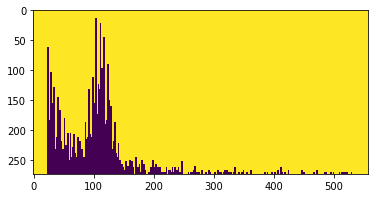

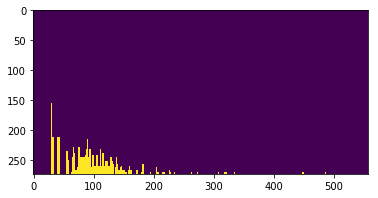

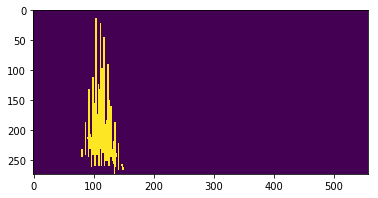

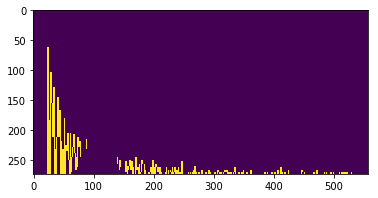

In [13]:
#use elbow method to separate color channels
masque_bar=kmeans_color_filter(img_bar,num_of_colors=None,
                               hsv_conversion=False,save_img=True)

#apparently the overlap is identified as a new cluster
for i in masque_bar:
    plt.imshow(masque_bar[i])
    plt.show()

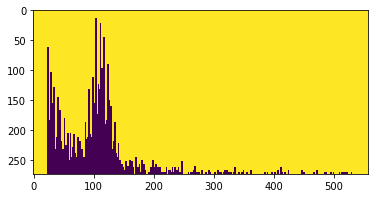

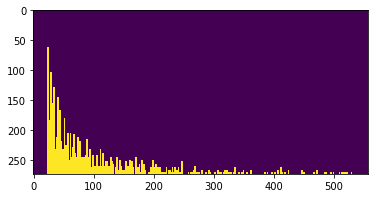

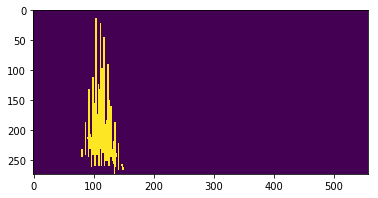

In [14]:
#specify 3 color channels
masque_bar=kmeans_color_filter(img_bar,num_of_colors=3,
                               hsv_conversion=False,save_img=True)

#now its what we want
for i in masque_bar:
    plt.imshow(masque_bar[i])
    plt.show()

In [15]:
#create bgr channels
rendered1=cv2.merge([masque_bar[1],masque_bar[1],masque_bar[1]])
rendered2=cv2.merge([masque_bar[2],masque_bar[2],masque_bar[2]])

#convert hex to bgr color
blue=PIL.ImageColor.getcolor("#878f99", "RGB")[::-1]
orange=PIL.ImageColor.getcolor("#c1946a", "RGB")[::-1]

#save rendered images
cv2.imwrite('rendered1.png',np.where(rendered1==[0,0,0],[255,255,255],blue))
cv2.imwrite('rendered2.png',np.where(rendered2==[0,0,0],[255,255,255],orange))

True

In [16]:
#extract coordinates
erm=read_xy_from_pixels(masque_bar[2],425,50,80,0,
                        vert_flip=True)

df_er=clean_df_bar(erm)

bam=read_xy_from_pixels(masque_bar[1],425,50,80,0,
                        vert_flip=True)

df_ba=clean_df_bar(bam)

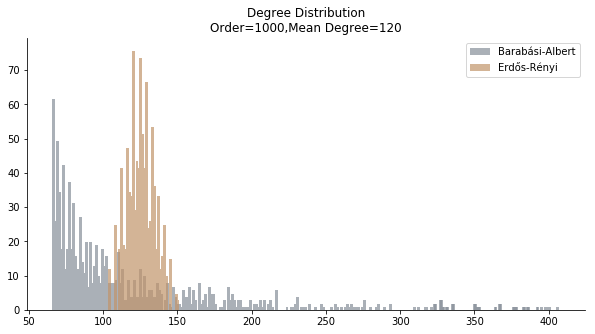

In [17]:
#reverse engineering
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(df_ba['x'],df_ba['y'],label='Barabási-Albert',color='#878f99',alpha=0.7)
plt.bar(df_er['x'],df_er['y'],label='Erdős-Rényi',color='#c1946a',alpha=0.7)
plt.legend(loc=0)
plt.title('Degree Distribution\nOrder=1000,Mean Degree=120')
plt.show()

&nbsp;
### Line Chart
&nbsp;

In [18]:
#the image comes from my smart farmer project
#remove title, legend, labels, axis
#the original image is in the following link
# https://github.com/je-suis-tm/quant-trading/blob/master/Smart%20Farmers%20project/preview/oil%20palm%20vs%20palm%20oil.png
#the modified image is in the following link
# https://github.com/je-suis-tm/machine-learning/blob/master/Reverse%20Engineering%20project/preview/line%20chart.png
img=cv2.imread('viz2.png',1)

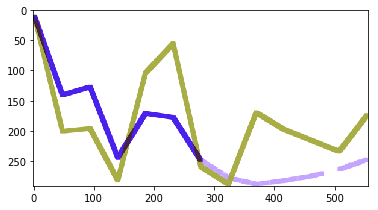

In [19]:
#connect dotted line via erosion
erosion_dotted=cv2.erode(img,np.ones((7,7),'uint8'),iterations=1)
cv2.imwrite("erosion1.png",erosion_dotted)

plt.imshow(erosion_dotted)

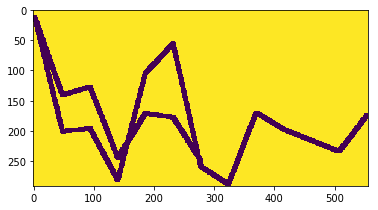

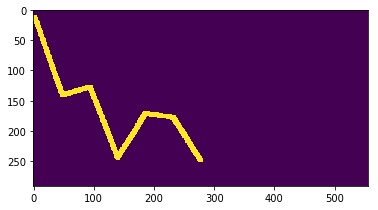

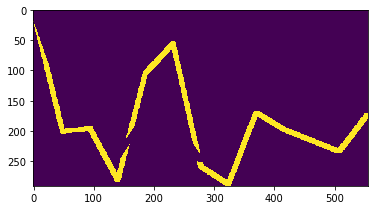

In [20]:
#use elbow method to separate color channels
masque_line=kmeans_color_filter(erosion_dotted,num_of_colors=None,
                                hsv_conversion=False,save_img=True)

#unfortunately the dotted line got treated as background color
for i in masque_line:
    plt.imshow(masque_line[i])
    plt.show()

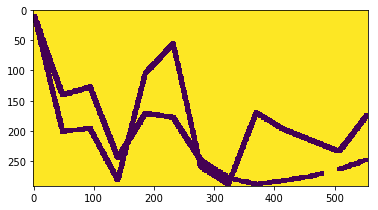

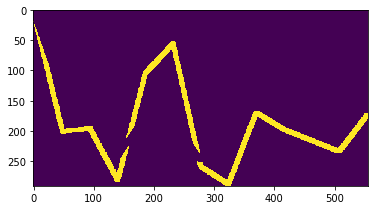

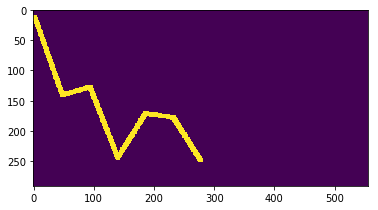

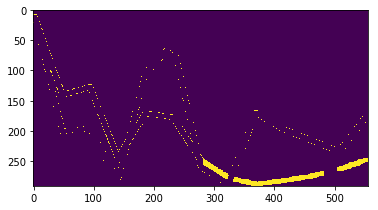

In [21]:
#specify 4 color channels
masque_line=kmeans_color_filter(erosion_dotted,num_of_colors=4,
                                hsv_conversion=False,save_img=True)

#successfully identify the dotted line (with some noise)
for i in masque_line:
    plt.imshow(masque_line[i])
    plt.show()

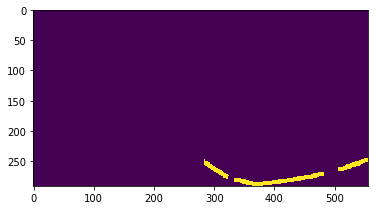

In [22]:
#use erosion to remove noise
erosion_noise=cv2.erode(masque_line[3],np.ones((2,2),'uint8'),iterations=1)
cv2.imwrite("erosion2.png",erosion_noise)

plt.imshow(erosion_noise)

In [23]:
#extract coordinates
forecast=read_xy_from_pixels(erosion_noise,2024,2012,200,100,
                        vert_flip=True)
df_for=clean_df_line(forecast)

oilpalm=read_xy_from_pixels(masque_line[2],2024,2012,200,100,
                        vert_flip=True)
df_op=clean_df_line(oilpalm)

palmoil=read_xy_from_pixels(masque_line[1],2024,2012,675,500,
                        vert_flip=True)
df_po=clean_df_line(palmoil)

In [24]:
#when you shrink data
#there is always information loss
#with that being said
#we can always recreate the exact image
#but we cannot reverse engineer the exact underlying data
df_for=shrink_data_size(df_for,range(2018,2025),mae=True)
df_op=shrink_data_size(df_op,range(2012,2019),mae=True)
df_po=shrink_data_size(df_po,range(2012,2025),mae=True)

In [25]:
#concatenate into one
output=pd.DataFrame()
output['x']=range(2012,2025)
output['y1']=df_po['y'].tolist()
output['y2']=df_op['y'].tolist()+df_for['y'].tolist()[1:]

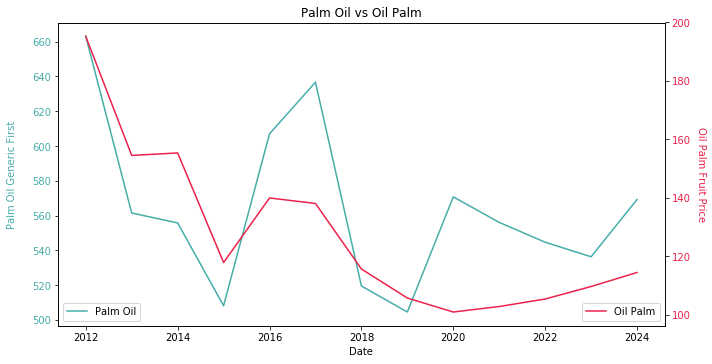

In [26]:
#reverse engineering
dual_axis_plot(output['x'],output['y1'],output['y2'],
               fst_color='#45ada8',sec_color='#ec2049',
               x_label='Date',y_label1='Palm Oil Generic First',
               y_label2='Oil Palm Fruit Price',
               legend1='Palm Oil',legend2='Oil Palm',
               title='Palm Oil vs Oil Palm')                   